#  注意
    1. onehot编码方式
    2. list + map + lambda + zip
    3. 二维数据多个label颜色可视化写法
    4. 线性回归做标准化前后异常值没有什么变化(没有被处理掉)

# Vast 汽车价格离群值检测 

异常值检测方法：有哪些比较好的做异常值检测的方法？ - 阿里云云栖社区的回答 - 知乎
https://www.zhihu.com/question/38066650/answer/549125707

离群点（Outliers），简单而言就是离其余数据点非常远的数据点。它们会极大的影响后续的分析结果，甚至产生有误导的分析结果。

Vast向3个行业的出版商、市场和搜索引擎提供数据，这三个行业包括汽车、房地产和休闲、住宿和旅游。Vast的系统通过白标签集成，并在一些非常受欢迎的消费应用程序（Southwest GetAway Finder，AOL Travel，Yahoo! Travel，Car and Driver等等）中提供搜索结果、产品建议和特别优惠。

Vast的汽车数据是由成千上万的二手汽车卖家提供，并且向市场公布。由于这些数据是由用户手工录入，因此容易受到人为失误的影响，比如用户在错误的字段中提交值，或者无意中发生错误或胖手指值。 对于8岁的车辆，里程表读数为100,000英里。 直觉告诉我们，100,000美元是大多数小型车的不寻常的价格。 一个上市的42000美元是合理的，比如2013年的凯迪拉克ATS豪华版，而对另一个（例如1997年的别克莱斯布雷）来说，这可能是意料之外的。

![2013cadillac](./img/2013cadillac.png)

![1997buick](./img/1997buick.png)

检测离群值有利于纠正错误，向用户提供卓越和合适的产品。

# 数据集描述

![vars](./img/vars.png)

# 导入数据集并切分

In [93]:
import pandas as pd # 读取数据表并进行基于DataFrame结构的操作
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # 不显示warning信息
pd.options.display.width = 900 # Dataframe 显示宽度设置

In [94]:
import os
os.chdir(r'C:\Users\heng.wang\AI\代码整理终版\beida\数据预处理\二数据预处理汽车价格离群值检测\dataset')

    画图配色方案
    绿色 #5dbe80
    蓝色 #2d9ed8
    紫色 #a290c4
    橙色 #efab40
    红色 #EE5150

In [95]:
train = pd.read_csv('accord_sedan_training.csv')
print('The shape is', train.shape)
train.head(7)

The shape is (417, 6)


,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic
5,10067,96966,2006,lx,4 Cyl,Automatic
6,8999,126150,2006,lx,4 Cyl,Automatic


In [96]:
# 将 train 划分为 x 和 y
train_x = train.drop('price', 1)
train_y = train['price']

# 特征提取并构建线性回归模型 

使用sklearn.feature_extraction中的DictVectorizer将名义型变量实现One-Hot编码，得到一个10维向量空间，包括：


    engine=4 Cyl
    engine=6 Cyl
    mileage
    price
    transmission=Automatic
    transmission=Manual
    trim=ex
    trim=exl
    trim=lx
    year

注意：在异常值检测时需要利用到  price  特征。

## one-hot编码方法之一：使用DictVectorizer实现

In [97]:
# One-Hot编码方法一：使用`DictVectorizer`实现
dv = DictVectorizer()
dv.fit(train.T.to_dict().values())  # one-hot 编码
print('Dimension is', len(dv.feature_names_))
dv.feature_names_

Dimension is 10


['engine=4 Cyl',
 'engine=6 Cyl',
 'mileage',
 'price',
 'transmission=Automatic',
 'transmission=Manual',
 'trim=ex',
 'trim=exl',
 'trim=lx',
 'year']

In [104]:
train_x_array = dv.transform(train_x.T.to_dict().values())
train_x_array

<417x10 sparse matrix of type '<class 'numpy.float64'>'
	with 2085 stored elements in Compressed Sparse Row format>

## one-hot编码方法之二：使用get_dummies实现

In [105]:
# One-Hot编码方法二：使用`pandas`的`get_dummies`函数实现
nomial_var = ['engine', 'trim', 'transmission']
multi_dummies = []  # 存储三个 DataFrame
train_x_dummies = train_x[['mileage', 'year']]
for col in nomial_var:
    dummies = pd.get_dummies(train_x[col], prefix=col)    # prefix是自定义前缀
    train_x_dummies = pd.concat(
        [train_x_dummies, dummies], axis=1)  # 将编码结果与非编码特征水平拼接起来
train_x_dummies.head()

,mileage,year,engine_4 Cyl,engine_6 Cyl,trim_ex,trim_exl,trim_lx,transmission_Automatic,transmission_Manual
0,67697,2006,1,0,1,0,0,0,1
1,73738,2006,1,0,1,0,0,0,1
2,80313,2006,1,0,0,0,1,1,0
3,86096,2006,1,0,0,0,1,1,0
4,79607,2006,1,0,0,0,1,1,0


In [106]:
# 构建线性回归模型
train_x_array = dv.transform(train_x.T.to_dict().values())
# train_x_array = train_x_dummies.values # 也可以使用get_dummies得到的结果

In [107]:
LR = LinearRegression().fit(train_x_array, train_y)


In [108]:
[format(LR.intercept_, '0.2f')] 

['16561.07']

In [109]:
[format(LR.intercept_, '0.2f')]  + list(map(lambda f,c: "(%0.2f %s)" % (c, f), 
               dv.feature_names_, LR.coef_))

['16561.07',
 '(-337.20 engine=4 Cyl)',
 '(337.20 engine=6 Cyl)',
 '(-0.05 mileage)',
 '(0.00 price)',
 '(420.68 transmission=Automatic)',
 '(-420.68 transmission=Manual)',
 '(208.93 trim=ex)',
 '(674.60 trim=exl)',
 '(-883.53 trim=lx)',
 '(-0.00 year)']

In [110]:
' + '.join([format(LR.intercept_, '0.2f')] 
           + list(map(lambda f,c: "(%0.2f %s)" % (c, f), 
               dv.feature_names_, LR.coef_)))

'16561.07 + (-337.20 engine=4 Cyl) + (337.20 engine=6 Cyl) + (-0.05 mileage) + (0.00 price) + (420.68 transmission=Automatic) + (-420.68 transmission=Manual) + (208.93 trim=ex) + (674.60 trim=exl) + (-883.53 trim=lx) + (-0.00 year)'

In [111]:
#[format(156.288, '0.2f')] + list(map(lambda x, y: '(%d %d)' % (x, y),[1, 3, 5, 7, 9], [2, 4, 6, 8, 10]))

In [112]:
#'+'.join([format(156.288, '0.2f')] + list(map(lambda x, y: '(%d %d)' % (x, y),[1, 3, 5, 7, 9], [2, 4, 6, 8, 10])))

# 离群值检测 

由测试集拟合得到的模型，我们可以预测测试集中的价格，计算每个样本的绝对误差，并得出

In [113]:
pred_y = LR.predict(dv.transform(train.T.to_dict().values()))
train_error = abs(pred_y - train_y)  # 计算绝对误差
np.percentile(train_error, [75, 90, 95, 99])  # 计算绝对误差数据的百分位数

array([1391.71708207, 2200.19426727, 2626.93763764, 3857.46054118])

画出 train_error 的盒图来观察离群值

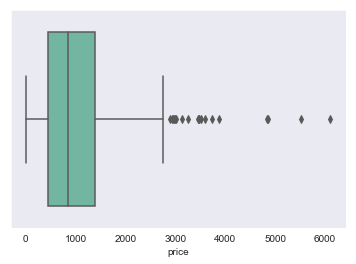

In [114]:
sns.boxplot(x = train_error,palette = "Set2")

可以看到测试集中存在部分离群值

在本案例中，我们设定置信水平为0.95，即认为超过95%百分位数的train_error为离群值。下面我们在二维空间中画出正常值（蓝色）与离群值（红色）：

In [115]:
outlierIndex = train_error >= np.percentile(train_error, 95)
inlierIndex = train_error < np.percentile(train_error, 95)

# 得到train_error最大的index值，即极端离群值
most_severe = train_error[outlierIndex].idxmax()

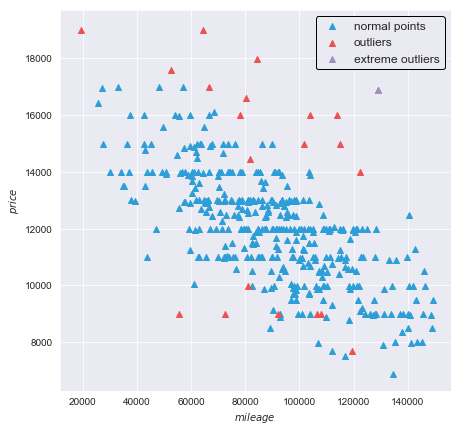

In [130]:
fig = plt.figure(figsize=(7, 7))
indexes = [inlierIndex, outlierIndex, most_severe]
color = ['#2d9ed8', '#EE5150', '#a290c4']
label = ['normal points', 'outliers', 'extreme outliers']
for i, c, l in zip(indexes, color, label):
    plt.scatter(train['mileage'][i],
                train_y[i],
                c=c,
                marker='^',
                label=l)
plt.legend(loc='upper right',
           frameon=True,
           edgecolor='k',
           framealpha=1,
           fontsize=12)
plt.xlabel('$mileage$')
plt.ylabel('$price$')
plt.grid('on')      # 显示背景的网格线 
sns.set_style('darkgrid')  # 主题：darkgrid, whitegrid, dark, white, ticks

In [122]:
plt.grid?

In [123]:
sns.set_style?

看一下离群值的数量有多少？

In [53]:
outlierIndex.value_counts()

False    396
True      21
Name: price, dtype: int64

上图结果也符合我们的经验理解，二手车的行驶公里数越高，它卖出去的价格就应该越低，所以对于处在右上和左下区域的点可能是一些离群值（对于同一款车而言）。比如左下区域的点，一些行驶里程数低，价格也比较低的车辆，有可能该车辆是事故车辆或者有损坏，而<span class="burk">右上区域的离群值有可能是真实的离群值</span>，相对来讲不容易有合理的解释，可能是输入失误或者胖手指输入造成。

本案例中的数据只有400多条，如果数据再多一些，则检测的结果会更加可靠。

# 标准化对离群值检测的影响 

通常情况下，为了避免不同尺度的影响。我们在进行<span class="burk">线性回归模型</span>拟合之前，需要对各个特征进行标准化。常见的标准化有z-score标准化、0-1标准化等，这里我们选择z-score标准化来观察标准化对离群值检测的影响。

## z-score标准化

In [132]:
# 利用 preprocessing.scale函数将特征标准化
columns = train_x_dummies.columns

In [133]:
columns

Index(['mileage', 'year', 'engine_4 Cyl', 'engine_6 Cyl', 'trim_ex', 'trim_exl', 'trim_lx', 'transmission_Automatic', 'transmission_Manual'], dtype='object')

In [134]:
train_x_zscore = pd.DataFrame(
    preprocessing.scale(train_x_dummies), columns=columns)
#train_y_zscore = pd.DataFrame(preprocessing.scale(pd.DataFrame(train_y,columns=['price'])),columns = ['price'])

In [135]:
# 线性模型拟合
LR_zscore = LinearRegression().fit(train_x_zscore.values, train_y)
' + '.join([format(LR_zscore.intercept_, '0.2f')]
           + list(map(lambda f, c: "(%0.2f %s)" % (c, f),
                 dv.feature_names_, LR_zscore.coef_)))

'12084.24 + (-1353.40 engine=4 Cyl) + (0.00 engine=6 Cyl) + (-166.91 mileage) + (166.91 price) + (225.03 transmission=Automatic) + (138.41 transmission=Manual) + (-274.18 trim=ex) + (116.65 trim=exl) + (-116.65 trim=lx)'

In [136]:
pred_y_zscore = LR_zscore.predict(train_x_zscore)
train_error_zscore = abs(pred_y_zscore - train_y)  # 计算绝对误差
np.percentile(train_error_zscore, [75, 90, 95, 99])  # 计算绝对误差数据的百分位数

array([1391.71708207, 2200.19426726, 2626.93763764, 3857.46054116])

In [137]:
outlierIndex_zscore = train_error_zscore >= np.percentile(train_error_zscore, 95)
inlierIndex_zscore = train_error_zscore < np.percentile(train_error_zscore, 95)
diff = (outlierIndex_zscore != outlierIndex)  # diff 用于存储标准化前后的离群值检测结果不同的index
diff.value_counts()

False    417
Name: price, dtype: int64

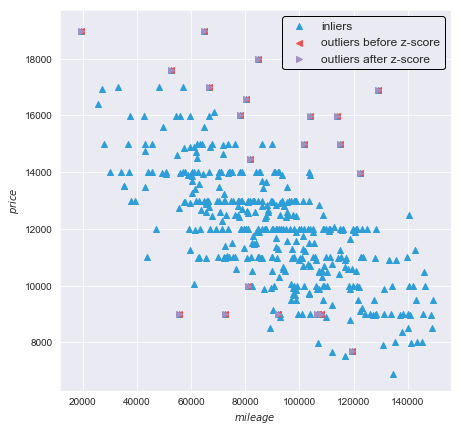

In [139]:
# 画出标准化前后的检测差异点
fig = plt.figure(figsize=(7, 7))

# rep_inlierIndex为标准化前后都为正常值的index
rep_inlierIndex = (inlierIndex == inlierIndex_zscore)

indexes = [rep_inlierIndex, outlierIndex, outlierIndex_zscore]
color = ['#2d9ed8', '#EE5150', '#a290c4']
markers = ['^', '<', '>']
label = ['inliers', 'outliers before z-score', 'outliers after z-score']
for i, c, m, l in zip(indexes, color, markers, label):
    plt.scatter(train['mileage'][i],
                train_y[i],
                c=c,
                marker=m,
                label=l)
plt.xlabel('$mileage$')
plt.ylabel('$price$')
plt.grid('on')
plt.legend(loc='upper right',
           frameon=True,
           edgecolor='k',
           framealpha=1,
           fontsize=12)
sns.set_style('dark')

从结果可以看到，绝大多数样本的检测结果一致。有两个样本存在差别，其中一个样本在标准化之前会被检测为离群值，另外一个样本在标准化之后会被检测为离群值。虽然在本例中，标准化前后的检测效果差异不是很大，但是仍然建议在线性建模之前对特征进行标准化。

# 测试集的验证

我们先以 mileage 为横坐标， price 为纵坐标画出训练集和测试集的所有样本点。

In [140]:
test = pd.read_csv('accord_sedan_testing.csv')

In [141]:
datasets = [train, test]

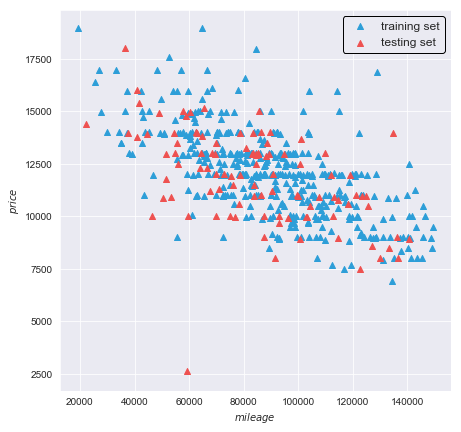

In [142]:
color = ['#2d9ed8', '#EE5150']
label = ['training set', 'testing set']
fig = plt.figure(figsize=(7, 7))
for i, c, l in zip(range(len(datasets)), color, label):
    plt.scatter(datasets[i]['mileage'],
                datasets[i]['price'],
                c=c,
                marker='^',
                label=l)
plt.xlabel('$mileage$')
plt.ylabel('$price$')
plt.grid('on')
plt.legend(loc='upper right',
           frameon=True,
           edgecolor='k',
           framealpha=1,
           fontsize=12)
sns.set_style('dark')

我们来看看利用在训练集上训练得到的模型在测试集上的泛化效果：

In [143]:
pred_y_test = LR.predict(dv.transform(test.T.to_dict().values()))
test_error = abs(pred_y_test - test['price'])

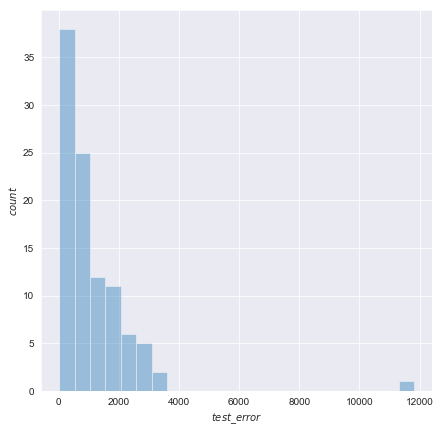

In [144]:
# 使用分布图观察测试集误差
fig = plt.figure(figsize=(7, 7))
sns.distplot(test_error, kde=False)
plt.xlabel('$test\_error$')
plt.ylabel('$count$')
plt.grid('on')

In [145]:
# 找出极端离群值
most_severe_test = test_error.idxmax()
test.iloc[most_severe_test]

price                2612
mileage             59308
year                 2006
trim                   ex
engine              6 Cyl
transmission    Automatic
Name: 49, dtype: object

从分布图中可以看到，我们的模型对测试集上其中一个样本的预测表现非常差。该样本是一个极端的离群样本。该车是一个6缸高配版的车，并且其已行驶英里数只有~60,000英里左右，但是其卖出的价格才$2612。

根据经验，我们猜测这个离群样本出现的两种可能：

在网站里填写时出错；
该车辆有车体的损伤或者有汽车所有权问题（偷来的或者劫来的）

# 在测试集上使用LOF进行离群值检测

In [146]:
test = pd.read_csv('accord_sedan_testing.csv')

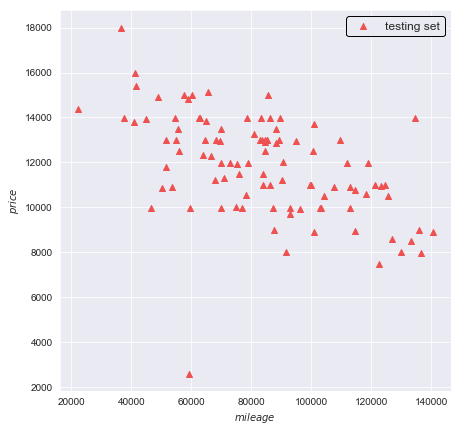

In [147]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(test['mileage'],
            test['price'],
            c='#EE5150',
            marker='^',
            label='testing set')
plt.xlabel('$mileage$')
plt.ylabel('$price$')
plt.grid('on')
plt.legend(loc='upper right',
           frameon=True,
           edgecolor='k',
           framealpha=1,
           fontsize=12)
sns.set_style('dark')

![LOF](./img/gongshi.png)

In [148]:
data = test[['mileage','price']]

In [79]:
# 导入sklearn用于计算最近邻相关数据的方法 NearestNeighbors
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 定义函数计算第k可达距离


def k_Distance(data, k):
    neigh = NearestNeighbors(k)
    model = neigh.fit(data)

    nums = data.shape[0]

    k_distance = []
    neighbor_info = []

    for index in range(nums):

        # K个距离
        dist = neigh.kneighbors([data[index]], n_neighbors=k + 1)
        # 最大的dist
        k_distance.append(dist[0][-1][-1])

        # neighbor为k个邻居的索引，dists为相应的距离
        dists, neighbor = neigh.radius_neighbors(
            [data[index]], radius=k_distance[index])

        # 排除自身
        mask = neighbor[0] != index
        neighbor_info.append([neighbor[0][mask], dists[0][mask]])
    return k_distance, neighbor_info

In [84]:
# 定义函数计算局部可达密度
def reach_density(data, k_distance, neighbor_info):

    nums = data.shape[0]
    density_list = []

    for index in range(nums):

        neighbors, dists = neighbor_info[index]
        nums_neigh = len(neighbors)

        sum_dist = 0

        for item in range(nums_neigh):

            k_dist_o = k_distance[neighbors[item]]

            direct_dist = dists[item]

            reach_dist_p_o = max(k_dist_o, direct_dist)

            sum_dist += reach_dist_p_o

        density_list.append(nums_neigh/sum_dist)

    return density_list

In [85]:
# 定义函数计算LOF因子
def cal_lof(index, data, neighbor_info, lrd_list):

    point_p = data[index]
    neighbors, _ = neighbor_info[index]

    nums_neigh = len(neighbors)
    sum_density = 0

    for item in range(nums_neigh):

        sum_density += lrd_list[item]

    return sum_density/(nums_neigh*lrd_list[index])

In [86]:
dists, neighbor_info = k_Distance(data.values, 2)

lrd_list = reach_density(data, dists, neighbor_info)

nums = data.shape[0]

lof_list = []

for index in range(nums):

    lof = cal_lof(index, data.values, neighbor_info, lrd_list)
    lof_list.append(lof)

boolean_array = [item > 5 for item in lof_list]

indicy = []
for key, value in enumerate(boolean_array):
    if value:
        indicy.append(key)

print (indicy)

[49, 52]


画出离群值

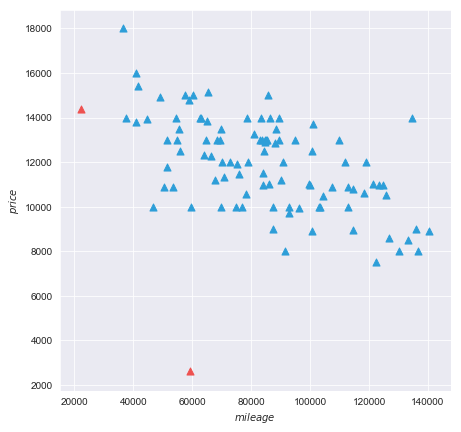

In [87]:
fig = plt.figure(figsize=(7, 7))
for i in data.index:
    if i not in indicy:
        plt.scatter(data.iloc[i]['mileage'],
                    data.iloc[i]['price'],
                    c='#2d9ed8',
                    s=50,
                    marker='^',
                    label='inliers')
    else:
        plt.scatter(data.iloc[i]['mileage'],
                    data.iloc[i]['price'],
                    c='#EE5150',
                    s=50,
                    marker='^',
                    label='outliers')
        plt.xlabel('$mileage$')
        plt.ylabel('$price$')
        plt.grid('on')

# 另外一种比较乱的写法

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
test_2d = test[['mileage', 'price']]
neigh = NearestNeighbors(5)  # 默认为欧式距离
model = neigh.fit(test_2d)

data = test_2d
# dist为每个样本点与第k距离邻域内的点的距离（包括自身）,neighbor为第k距离邻域点的编号（包括自身）
dist, neighbor = neigh.kneighbors(test_2d, n_neighbors=6)

k_distance_p = np.max(dist, axis=1)

nums = data.shape[0]
lrdk_p = []
lof = []
for p_index in xrange(nums):
    rdk_po = []
    neighbor_p = neighbor[p_index][neighbor[p_index] != p_index]
    for o_index in neighbor_p:
        rdk_po.append(max(k_distance_p[o_index], int(
            dist[p_index][neighbor[p_index] == o_index])))
    lrdk_p.append(float(len(neighbor_p))/sum(rdk_po))

for p_index in xrange(nums):
    lrdk_o = []
    neighbor_p = neighbor[p_index][neighbor[p_index] != p_index]
    for o_index in neighbor_p:
        lrdk_o.append(lrdk_p[o_index])
    lof.append(float(sum(lrdk_o))/(len(neighbor_p)*(lrdk_p[p_index])))

fig = plt.figure(figsize=(7, 7))

for index, size in zip(xrange(nums), lof):
    if index in indicy:
        plt.scatter(data['mileage'][index],
                    data['price'][index],
                    s=np.exp(lof[index])*50,
                    c='#efab40',
                    alpha=0.6,
                    marker='o')
        plt.text(data['mileage'][index]-np.exp(lof[index])*50,
                 data['price'][index]-np.exp(lof[index])*50,
                 str(round(lof[index], 2)))
    else:
        plt.scatter(data['mileage'][index],
                    data['price'][index],
                    s=np.exp(lof[index])*50,
                    c='#5dbe80',
                    alpha=0.6,
                    marker='o')
        plt.text(data['mileage'][index]-np.exp(lof[index])*50,
                 data['price'][index]-np.exp(lof[index])*50,
                 str(round(lof[index], 2)),
                 fontsize=7)

plt.xlabel('mileage')
plt.ylabel('price')
plt.grid('off')

# 尝试使用 oneclassSVM、IsolationForest和Robust covariance方法对离群价格进行检测